<a href="https://colab.research.google.com/github/tummalapallimurali/GenAI/blob/main/Machine_Abnormality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$ y= a + b x + c x^2 + d^3 $ \
$ loss = (y-y_{pred})^2 /2 $

In [1]:
#@title Gradient descent testing

# Gradient descent weights for a function

import numpy as np
import math

# random inputs
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# initialize weights

a = np.random.rand()
b = np.random.rand()
c = np.random.rand()
d = np.random.rand()

# y = a + b x + c x^2 + d x^3

#y_pred = a + b * x + c * x^2 + d * x ^ 3

learning_rate = 0.001

# forward pass

for i in range(100):
  y_pred = a + b * x + c * x**2 + d * x**3
  loss = np.square(np.subtract(y, y_pred)).mean()

  # back prop to update weights w.r.t loss

  grad_y_pred = 2 * (y - y_pred)
  grad_a = grad_y_pred.mean()
  grad_b = (grad_y_pred * x).mean()
  grad_c = (grad_y_pred * x**2).mean()
  grad_d = (grad_y_pred * x**3).mean()

  # update weights
  a -= learning_rate * grad_a
  b -= learning_rate * grad_b
  c -= learning_rate * grad_c
  d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')







Result: y = 8.502010043249173 + 7297146692.26684 x + 43.860868890875366 x^2 + 51301184021.576805 x^3


In [2]:
import requests
import json
import shutil
import os
import torch
import torchaudio
import tensorflow as tf


import torchaudio.transforms as T
import numpy
import sys
from matplotlib import pyplot as plt


# Analyze Audio Files: We will choose Fan recordings

In [3]:
#@title Get zip files from zenodo , extract and store in drive

directory = '/content/drive/MyDrive/GenAI Course/Data Set'

if not os.path.exists(directory):
  download_link = "https://zenodo.org/records/3384388/files/-6_dB_fan.zip?download=1"
  response = requests.get(download_link, stream=True)
  with open("-6_dB_fan.zip", "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
  !unzip /content/-6_dB_fan.zip
  shutil.move('/content/fan', '/content/drive/MyDrive/GenAI Course/Data Set')
else:
  print("folder already exists")

sample_wav_abn = directory + '/fan/id_00/abnormal/00000000.wav'
sample_wav_nor = directory + '/fan/id_00/normal/00000000.wav'
metadata = torchaudio.info(sample_wav_abn)

print("metadata for abnormal", metadata)

metadata = torchaudio.info(sample_wav_nor)

print("metadata for normal", metadata)




folder already exists
metadata for abnormal AudioMetaData(sample_rate=16000, num_frames=160000, num_channels=8, bits_per_sample=16, encoding=PCM_S)
metadata for normal AudioMetaData(sample_rate=16000, num_frames=160000, num_channels=8, bits_per_sample=16, encoding=PCM_S)


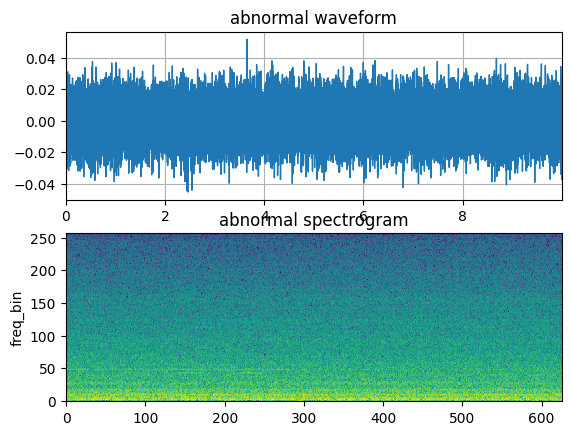

In [6]:
'''
This block of code, reads the wave form of audio and extracts the spectrogram.

https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

'''

import matplotlib.pyplot as plt
import librosa
import torch
import torchaudio.transforms as T

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


waveform, sample_rate = torchaudio.load(sample_wav_nor)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(waveform)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="abnormal waveform", ax=axs[0])
plot_spectrogram(spec[7], title="abnormal spectrogram", ax=axs[1])
#fig.tight_layout()
from IPython.display import Audio
Audio(waveform.numpy(), rate=sample_rate)


# Data Preperation

In [5]:
#@title get_files_and_labels
%%writefile utils.py

import os

def get_files_and_labels(directory):
    """
    Gets the file paths and labels for normal and abnormal audio files.

    Args:
        directory: The root directory containing machine ID folders and subfolders.

    Returns:
        A tuple containing six lists:
            files: A list of file paths for all audio files.
            labels: A list of labels (0 for normal, 1 for abnormal) corresponding to the files.
            normal_files: A list of file paths for normal audio files.
            normal_labels: A list of labels for normal audio files.
            abnormal_files: A list of file paths for abnormal audio files.
            abnormal_labels: A list of labels for abnormal audio files.
    """

    files = []
    labels = []

    # Iterate through machine ID folders and subfolders
    for machine_id in os.listdir(directory):
        machine_dir = os.path.join(directory, machine_id)
        for subfolder in ['normal', 'abnormal']:
            subfolder_dir = os.path.join(machine_dir, subfolder)

            # Check if the subfolder exists
            if os.path.isdir(subfolder_dir):
                # Iterate through files in the subfolder
                for filename in os.listdir(subfolder_dir):
                    if filename.endswith('.wav'):  # Assuming your files are WAV files
                        file_path = os.path.join(subfolder_dir, filename)
                        files.append(file_path)
                        labels.append(0 if subfolder == 'normal' else 1)  # Assign labels

    # Separate files and labels into normal and abnormal sets
    normal_files = [files[i] for i in range(len(files)) if labels[i] == 0]
    normal_labels = [0] * len(normal_files)  # All normal labels are 0
    abnormal_files = [files[i] for i in range(len(files)) if labels[i] == 1]
    abnormal_labels = [1] * len(abnormal_files)  # All abnormal labels are 1

    return files, labels, normal_files, normal_labels, abnormal_files, abnormal_labels

# Example usage:
directory = '/content/drive/MyDrive/GenAI Course/Data Set/fan'
files, labels, normal_files, normal_labels, abnormal_files, abnormal_labels = get_files_and_labels(directory)


# training files and evaluation files

train_files = normal_files[len(abnormal_files):]
train_labels = normal_labels[len(abnormal_files):]
eval_files = abnormal_files + normal_files[:len(abnormal_files)]
eval_labels = abnormal_labels + normal_labels[:len(abnormal_files)]

print("train_file num : {num}".format(num=len(train_files)))
print("eval_file  num : {num}".format(num=len(eval_files)))

def prepare_data(directory):
  _ , _, normal_files, normal_labels, abnormal_files, abnormal_labels = get_files_and_labels(directory)
  train_files = normal_files[len(abnormal_files):]
  train_labels = normal_labels[len(abnormal_files):]
  eval_files = abnormal_files + normal_files[:len(abnormal_files)]
  eval_labels = abnormal_labels + normal_labels[:len(abnormal_files)]
  return train_files, train_labels, eval_files, eval_labels

training_files, training_labels, evalu_files, evalU_labels = prepare_data(directory)





Writing utils.py


* There are 5500 total files (4075 normal(74%) and 1475(36%) abnormal samples)
* These are unbalanced samples, to keep the balance training files contained (2600) samples and eval files contains 2950.
* Training file contains only Normal files and Eval file contains normal and abnromal files.

In [6]:
# convert this to a function for each training fil
def dataset_prep(training_files, n_mels=64, frames=5, n_fft=1024, hop_length=512, power=2.0):
  dims = n_mels * frames
  for i in range(len(training_files)):
    waveform, sample_rate = torchaudio.load(training_files[i])
    melspec = T.MelSpectrogram(sample_rate, n_fft=1024,hop_length=512, n_mels=64,power=2.0)
    spec = melspec(waveform)
    log = 20.0 / power * numpy.log10(spec + sys.float_info.epsilon)
    vector_size = log.shape[2] - frames + 1
    vectorarray = numpy.zeros((vector_size, dims), float)
    for t in range(frames):
      vectorarray[:, n_mels * t: n_mels * (t + 1)] = log[0,:, t: t + vector_size].T
    dataset = numpy.zeros((vector_size * len(training_files[0]), dims), float)
    dataset[vectorarray.shape[0] * i: vectorarray.shape[0] * (i + 1), :] = vectorarray
    return dataset


In [7]:
#@title encode-decoder.py
%%writefile encode-decoder.py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class AnomolyDetector(Model):
    def __init__(self, input_shape): # Add input_shape parameter
        super(AnomolyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(input_shape, activation="sigmoid") # Use input_shape for output layer
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Writing encode-decoder.py


In [8]:
#@title visalizer.py
%%writefile visualizer.py

class visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss, val_loss):
        """
        Plot loss curve.

        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.

        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        ax.plot(val_loss)
        ax.set_title("Model loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Test"], loc="upper right")

Writing visualizer.py


In [9]:
#@title datapreprocessing.py
%%writefile datapreprocessing.py

import tqdm
import logging
import sys
import os
import glob
import librosa
import numpy

def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, numpy.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')

def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, fearture_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * numpy.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vectorarray_size < 1:
        return numpy.empty((0, dims), float)

    # 06 generate feature vectors by concatenating multi_frames
    vectorarray = numpy.zeros((vectorarray_size, dims), float)
    for t in range(frames):
        vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return vectorarray

def list_to_vector_array(file_list,
                         msg="calc...",
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.

    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.

    return : numpy.array( numpy.array( float ) )
        training dataset (when generate the validation data, this function is not used.)
        * dataset.shape = (total_dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 loop of file_to_vectorarray
    for idx in tqdm.tqdm(range(len(file_list)), desc=msg):

        vector_array = file_to_vector_array(file_list[idx],
                                            n_mels=n_mels,
                                            frames=frames,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)

        if idx == 0:
            dataset = numpy.zeros((vector_array.shape[0] * len(file_list), dims), float)

        dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :] = vector_array

    return dataset




Writing datapreprocessing.py


In [10]:
#@title datasetgenerator.py(Returns training, test and evaluations labels)
%%writefile datasetgenerator.py

import logging
import sys
import os
import glob
import numpy
import random

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def dataset_generator(target_dir,
                      normal_dir_name="normal",
                      abnormal_dir_name="abnormal",
                      ext="wav"):
    """
    target_dir : str
        base directory path of the dataset
    normal_dir_name : str (default="normal")
        directory name the normal data located in
    abnormal_dir_name : str (default="abnormal")
        directory name the abnormal data located in
    ext : str (default="wav")
        filename extension of audio files

    return :
        train_data : numpy.array( numpy.array( float ) )
            training dataset
            * dataset.shape = (total_dataset_size, feature_vector_length)
        train_files : list [ str ]
            file list for training
        train_labels : list [ boolean ]
            label info. list for training
            * normal/abnormal = 0/1
        eval_files : list [ str ]
            file list for evaluation
        eval_labels : list [ boolean ]
            label info. list for evaluation
            * normal/abnormal = 0/1
    """
    logger.info("target_dir : {}".format(target_dir))

    # 01 normal list generate
    normal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                 normal_dir_name=normal_dir_name,
                                                                 ext=ext))))
    normal_labels = numpy.zeros(len(normal_files))
    if len(normal_files) == 0:
        logger.exception("no_wav_data!!")

    # 02 abnormal list generate
    abnormal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                   ext=ext))))
    abnormal_labels = numpy.ones(len(abnormal_files))
    if len(abnormal_files) == 0:
        logger.exception("no_wav_data!!")

    # 03 separate train & eval
    train_files = normal_files[len(abnormal_files):]
    train_labels = normal_labels[len(abnormal_files):]
    eval_files = numpy.concatenate((normal_files[:len(abnormal_files)], abnormal_files), axis=0)
    eval_labels = numpy.concatenate((normal_labels[:len(abnormal_files)], abnormal_labels), axis=0)
    logger.info("train_file num : {num}".format(num=len(train_files)))
    logger.info("eval_file  num : {num}".format(num=len(eval_files)))

    return train_files, train_labels, eval_files, eval_labels


Writing datasetgenerator.py


In [11]:
#@title baseline model
%%writefile keras_baseline_model.py

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def keras_model(inputDim):
    """
    define the keras model
    the model based on the simple dense auto encoder (64*64*8*64*64)
    """
    inputLayer = Input(shape=(inputDim,))
    h = Dense(64, activation="relu")(inputLayer)
    h = Dense(64, activation="relu")(h)
    h = Dense(8, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(inputDim, activation=None)(h)

    return Model(inputs=inputLayer, outputs=h)



Writing keras_baseline_model.py


In [12]:
#@title encoder-decoder model
%%writefile keras_encoder_decoder_model.py

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def keras_model(inputDim):
    """
    Defines the Keras model with separate encoder and decoder.
    """
    # Encoder
    inputLayer = Input(shape=(inputDim,))
    h = Dense(64, activation="relu")(inputLayer)
    h = Dense(64, activation="relu")(h)
    encoded = Dense(8, activation="relu")(h)  # Encoded representation

    encoder = Model(inputs=inputLayer, outputs=encoded, name="encoder")

    # Decoder
    encoded_input = Input(shape=(8,))  # Input to the decoder
    h = Dense(64, activation="relu")(encoded_input)
    h = Dense(64, activation="relu")(h)
    decoded = Dense(inputDim, activation=None)(h)  # Decoded output

    decoder = Model(inputs=encoded_input, outputs=decoded, name="decoder")

    # Autoencoder (optional, if you still need it)
    autoencoder = Model(inputs=inputLayer, outputs=decoder(encoder(inputLayer)), name="autoencoder")

    return encoder, decoder, autoencoder

Writing keras_encoder_decoder_model.py


In [13]:
#@title start training

from datapreprocessing import *
from datasetgenerator import *

from visualizer import visualizer

target_dir = '/content/drive/MyDrive/GenAI Course/Data Set/fan/id_06'

train_files, train_labels, eval_files, eval_labels = dataset_generator(target_dir)

train_data = list_to_vector_array(train_files, msg="train_data")
eval_data = list_to_vector_array(eval_files, msg="eval_data")


eval_data: 100%|██████████| 722/722 [01:54<00:00,  6.33it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 320)                 │          20,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,760 (198.28 KB)

 Trainable params: 50,760 (198.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 26.0854 - val_loss: 8.3345
Epoch 2/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 6.4284 - val_loss: 7.9173
Epoch 3/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 6.1299 - val_loss: 7.6800
Epoch 4/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 6.0192 - val_loss: 7.6169
Epoch 5/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 5.9511 - val_loss: 7.7021
Epoch 6/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 5.8674 - val_loss: 7.5247
Epoch 7/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 5.8213 - val_loss: 7.4803
Epoch 8/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 5.7917 - val_loss: 7.4570
Epoch 9/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 5.7517 - val_loss: 7.4070
Epoch 10/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 5.7299 - val_loss: 7.4449


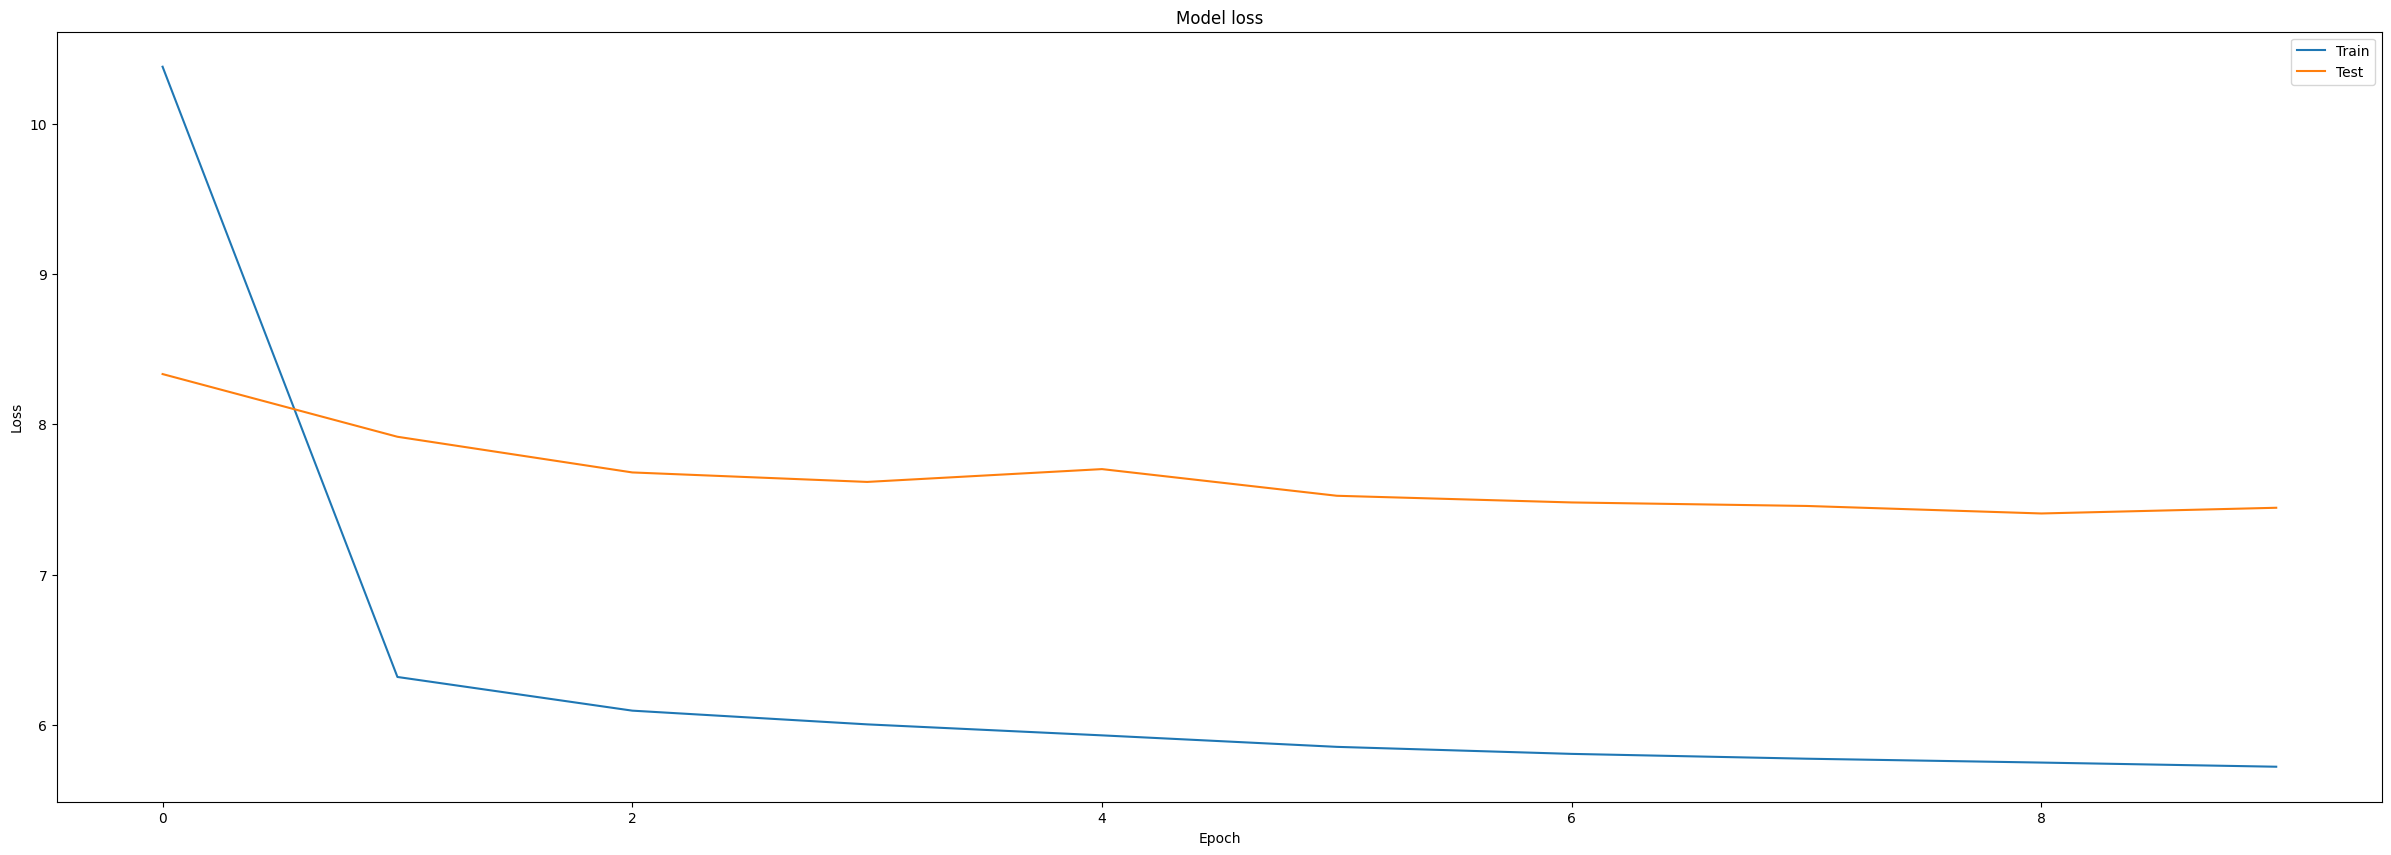

In [14]:
from keras_baseline_model import *

input_dim = train_data.shape[1]
model = keras_model(input_dim)
model.summary()

model.compile(optimizer='adam', loss='mse')
training = model.fit(train_data, train_data,
                     epochs=10,
                     batch_size=32,
                     validation_data=(eval_data, eval_data),
                     shuffle=True)

visualizer = visualizer()
visualizer.loss_plot(training.history['loss'], training.history['val_loss'])

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 8)                   │          25,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 320)                 │          25,536 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,760 (198.28 KB)

 Trainable params: 50,760 (198.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 28.5988 - val_loss: 10.8500
Epoch 2/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 8.8337 - val_loss: 10.5568
Epoch 3/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 8.5889 - val_loss: 10.0697
Epoch 4/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 8.2419 - val_loss: 10.3087
Epoch 5/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 8.0924 - val_loss: 9.0283
Epoch 6/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 7.1429 - val_loss: 8.6023
Epoch 7/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 6.5803 - val_loss: 8.2952
Epoch 8/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 6.4474 - val_loss: 8.1654
Epoch 9/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 6.3645 - val_loss: 8.1609
Epoch 10/10
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 6.2959 - val_loss: 8.0962


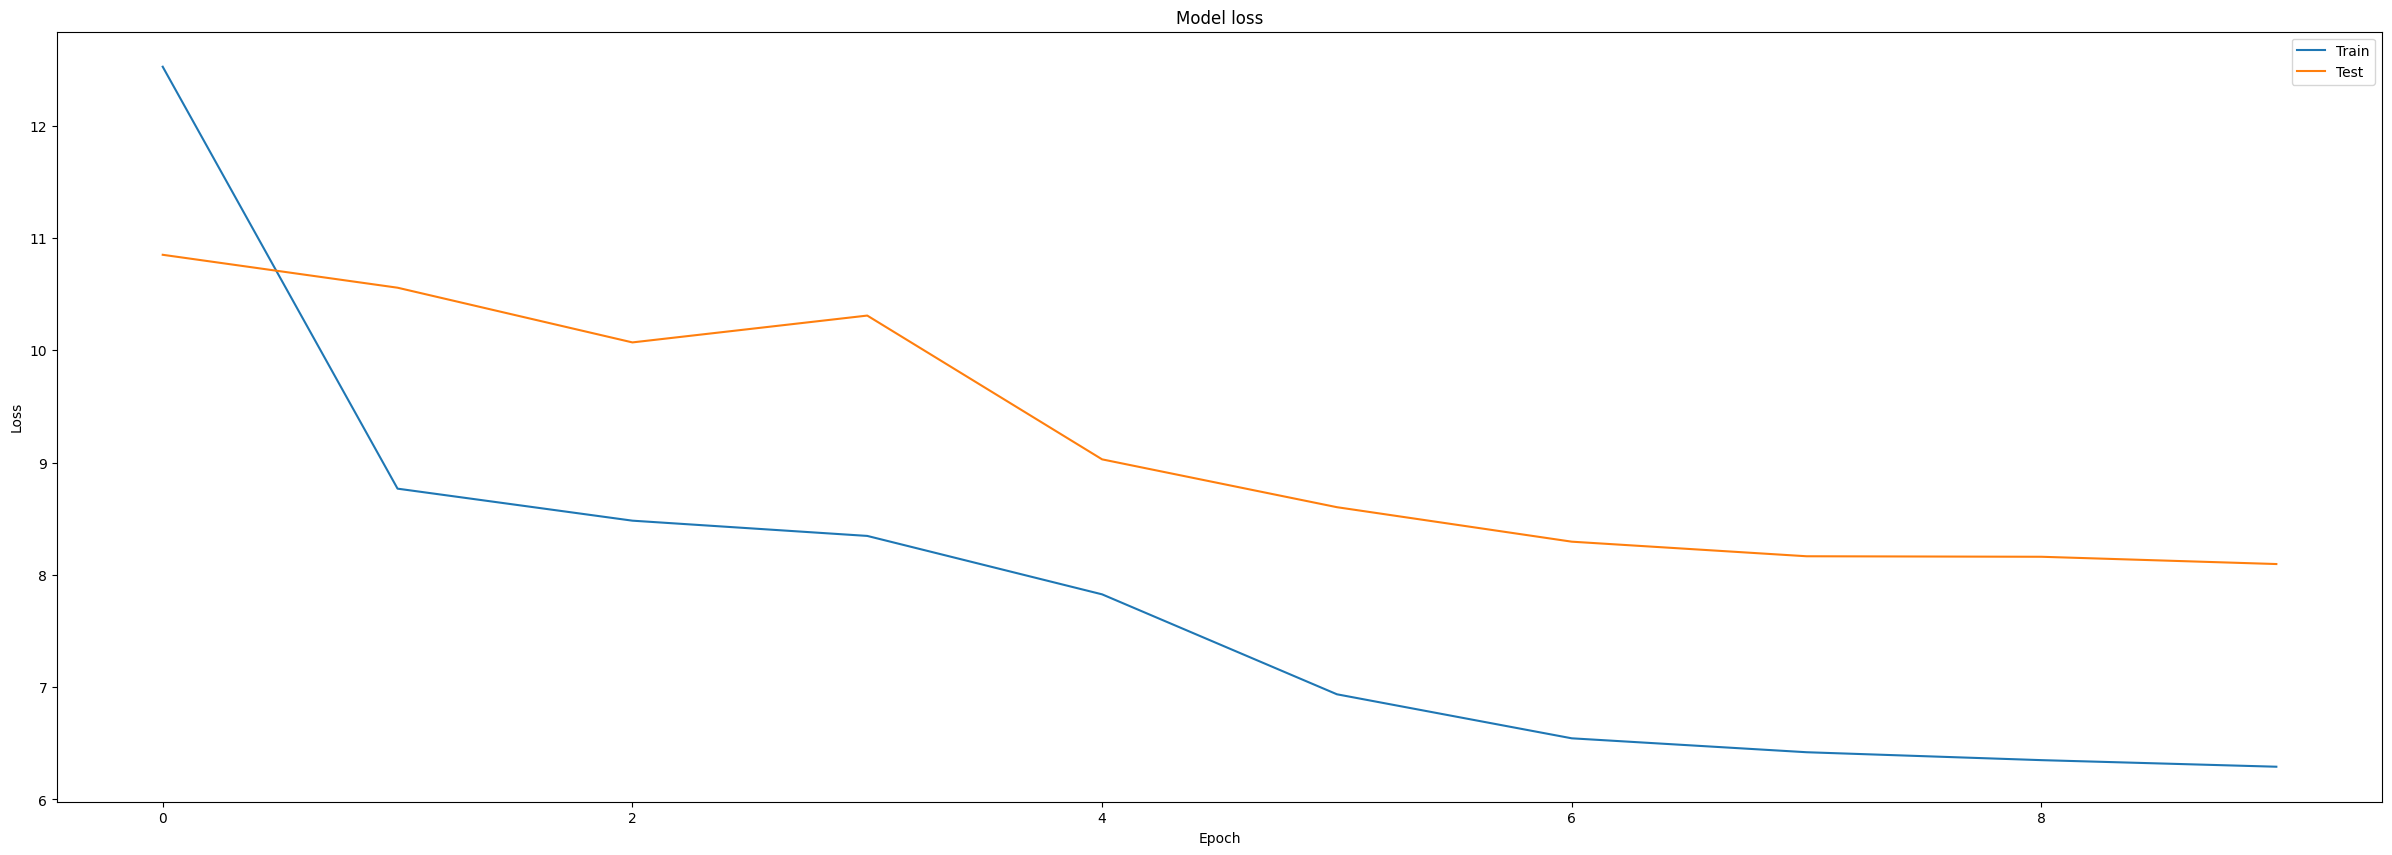

In [15]:
from keras_encoder_decoder_model import *
from visualizer import visualizer

input_dim = train_data.shape[1]
encoder, decoder, autoencoder = keras_model(input_dim)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mse') # test with loss = binary_crossentropy
history = autoencoder.fit(train_data, train_data,
                          epochs=10,
                          batch_size=32,
                          validation_data=(eval_data, eval_data),
                          shuffle=True)

visualizer = visualizer()
visualizer.loss_plot(history.history['loss'], history.history['val_loss'])

6316/6316 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


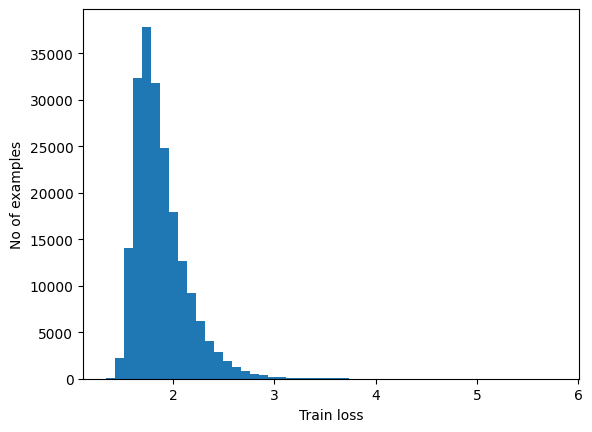

Threshold:  2.1362063810203327


In [18]:
history = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(history, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

threshold = numpy.mean(train_loss) + numpy.std(train_loss)
print("Threshold: ", threshold)


6972/6972 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


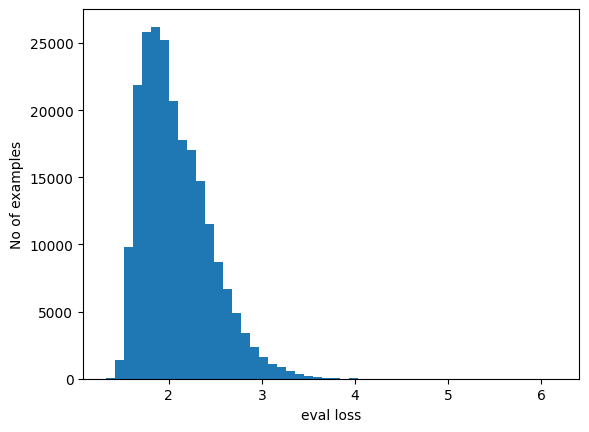

Threshold:  2.4478725993051413


In [19]:
history = autoencoder.predict(eval_data)
train_loss = tf.keras.losses.mae(history, eval_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("eval loss")
plt.ylabel("No of examples")
plt.show()

threshold = numpy.mean(train_loss) + numpy.std(train_loss)
print("Threshold: ", threshold)

In [21]:
# classify as anomaly if the reconstruction error is greater than threshold

def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

# def print_stats(predictions, labels):
#     print("Accuracy = {}".format(accuracy_score(labels, predictions)))
#     print("Precision = {}".format(precision_score(labels, predictions)))
#     print("Recall = {}".format(recall_score(labels, predictions)))

predictions = predict(autoencoder, eval_data, threshold)
#print_stats(predictions, eval_labels)

predictions

6972/6972 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


<tf.Tensor: shape=(223098,), dtype=bool, numpy=array([ True,  True,  True, ..., False, False,  True])>

6316/6316 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


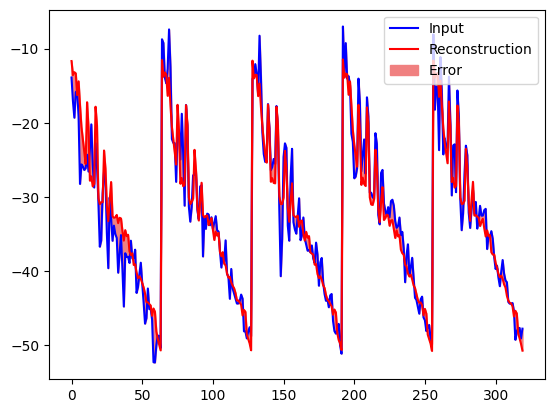

In [27]:
# reconstruct the error
import matplotlib.pyplot as plt
import numpy as np

encoded_data = encoder.predict(train_data)
decoded_data = decoder.predict(encoded_data)
train_loss = tf.keras.losses.mae(decoded_data, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

plt.plot(train_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(320), decoded_data[0], train_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

6972/6972 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6316/6316 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


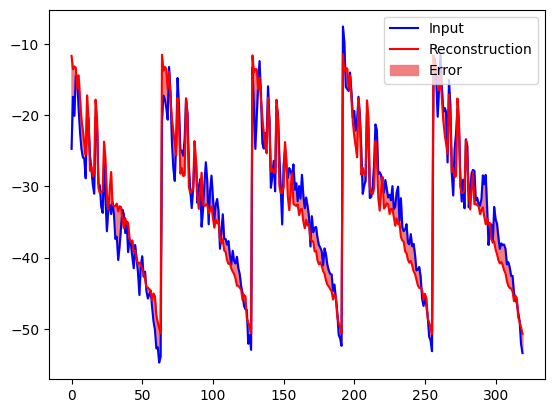

In [28]:
encoded_data1 = encoder.predict(eval_data)
decoded_data1 = decoder.predict(encoded_data)

plt.plot(eval_data[0], 'b')
plt.plot(decoded_data1[0], 'r')
plt.fill_between(np.arange(320), decoded_data1[0], eval_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


In [ ]:
from datapreprocessing import *
from datasetgenerator import *
from tqdm import tqdm

def roc_auc_score(eval_files, eval_label, model):
  y_pred = [0. for k in eval_labels]
  y_true = eval_labels

  for num, file_name in tqdm(enumerate(eval_files), total=len(eval_files)):
    try:
      data = file_to_vector_array(file_name)
      error = numpy.mean(numpy.square(data - model.predict(data)), axis=1)
      y_pred[num] = numpy.mean(error)
    except:
      logger.warning("File broken!!: {}".format(file_name))
  roc_auc_score = metrics.roc_auc_score(y_true, y_pred)
  # get accuracy, precisio, recall
  pred_binary = [1 if p > 2.4 else 0 for p in y_pred]
  accuracy = accuracy_score(y_true, pred_binary)
  precision = precision_score(y_true, pred_binary)
  recall = recall_score(y_true, pred_binary)
  return roc_auc_score, accuracy, precision, recall


print("roc_auc_score: {}".format(roc_auc_score(eval_files, eval_labels, autoencoder)))


# roc_auc_score, accuracy , precision, recall :
* # Autoencoder: : (0.871, 0.5, 0.5, 1.0)
* # Baseline model:(0.89, 0.5, 0.5, 1.0)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
encoded_data = autoencoder.encoder(train_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(eval_files[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(320), decoded_data[0], train_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()